In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Loading in data

In [2]:
def getNumFromOneHot(inp):
    for i in range(10):
        if inp[i] == 1:
            return i

In [5]:
def draw_stroke_sequence(sequence, save_path=None, show=True):
    """
    sequence: numpy array or list of shape (T, 4) where each row is [dx, dy, eos, eod]
    save_path: optional path to save the plot as an image
    show: whether to display the plot
    """
    x, y = 0, 0
    xs, ys = [], []

    for dx, dy, eos, eod in sequence:
        x += dx*28
        y += dy*28
        xs.append(x)
        ys.append(y)

        if eos > 0.5:  # end of stroke
            xs.append(None)
            ys.append(None)

        if eod > 0.5:
            break

    plt.figure(figsize=(2, 2))
    plt.plot(xs, ys, linewidth=2)
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.axis('equal')
    
    plt.show()

In [6]:
datas = [[] for _ in range(10)]

for i in range(10000):
    try:
        data = np.loadtxt(f'../sequences/testimg-{i}-targetdata.txt', delimiter=' ')
    except FileNotFoundError:
        print(f"❌ File not found at path: {i}")
        continue
    
    inputOneshot = data[0, 0:10]
    outputStrokes = data[:, 10:]
    outputStrokes[:, 0] = outputStrokes[:, 0]/28
    outputStrokes[:, 1] = outputStrokes[:, 1]/28
    
    datas[getNumFromOneHot(inputOneshot)].append(outputStrokes)

In [12]:
input_data = []
output_data = []

for i in range(10):
    temp_onehot = np.zeros(10)
    temp_onehot[i] = 1
    
    smallest_10 = sorted(datas[i], key=len)[:100]
    for k in smallest_10:
        input_data.append(temp_onehot)
        output_data.append(k)

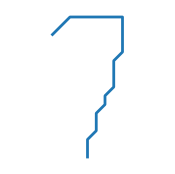

In [ ]:
draw_stroke_sequence(output_data[782])

# 0: [0, 3, 5, 10, 12, 16, 18, 20, 21, 22]
# 1: [100, 101, 102, 103, 104, 105, 107, 109, 110, 112]
# 2: [213, 218, 221, 230, 232, 234, 241, 249, 253, 254]
# 3; [314, 325, 327, 345, 347, 350, 354, 358, 365, 366]
# 4: [403, 405, 414, 415, 430, 434, 438, 439, 450, 464]
# 5: [500, 524, 527, 531, 532, 545, 549, 558, 565, 569]
# 6: [625, 627, 628, 643, 659, 661, 671, 676, 679 ,682]
# 7: [712, 714, 723, 727, 729, 730, 736, 782, 795, 799]
# 8: 
# 9

Data Processing

In [58]:
# Finding the max length of a sequence
max_length = 0
j = 0
for i in range(len(output_data)):
    if len(output_data[i]) > max_length:
        max_length = len(output_data[i])
    j += 1

print(max_length)
print(j)

44
1000


In [59]:
print(len(output_data))

1000


In [60]:
# Padding the sequences so that they are all the same size (good for batching)
padded_output_data = np.zeros( (len(output_data), max_length, 4) )

for i in range(len(output_data)):
    padded_output_data[i, :len(output_data[i]), :] = output_data[i]
    padded_output_data[i, len(output_data[i]):, :] = [0, 0, 0, 1]

In [61]:
padded_input_data = np.zeros( (len(output_data), max_length, 4) )

for i in range(len(output_data)):
    padded_input_data[i, 0, :] = [0, 0, 0, 0]
    padded_input_data[i, 1:, :] = padded_output_data[i, :max_length-1, :]

In [62]:
class StrokeDataset(Dataset):
    def __init__(self, onehot, inputs, outputstroke):
        self.digit = onehot                     # shape: [N]
        self.inputstroke = inputs               # list of [seq_len, 4] arrays
        self.outputstroke = outputstroke        # list of [seq_len, 4] arrays

    def __len__(self):
        return len(self.digit)

    def __getitem__(self, idx):
        digit = self.digit[idx]
        inputs = self.inputstroke[idx]
        outputs = self.outputstroke[idx]
        return torch.tensor(digit, dtype=torch.float32), torch.tensor(inputs, dtype=torch.float32), torch.tensor(outputs, dtype=torch.float32)

In [63]:
strokeDataset = StrokeDataset(input_data, padded_input_data, padded_output_data)

In [64]:
loader = DataLoader(strokeDataset, batch_size=16, shuffle=True)

Creating Model

Notes


RNN:
input_size = output_size 


In [65]:
class DigitToStrokeLSTM(nn.Module):
    def __init__(self, hidden_size=256, num_layers=2, batch_size=32):
        super(DigitToStrokeLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        
        self.embedding = nn.Linear(10, hidden_size)  # From one-hot to hidden dim
        
        # LSTM
        # Output layer: predicts [dx, dy, eos, eod]
        # Inital hidden state is the one-hot of number
        # Initial input is [0, 0, 0, 0, 0]
        # Input at t > 0 is output from t-1
        
        self.lstm = nn.LSTM(
            input_size=4,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        # Output layer: predicts [dx, dy, eos, eod]
        self.output_head = nn.Linear(hidden_size, 4)
        self.sigmoid = nn.Sigmoid()  # For eos/eod
        self.tanh = nn.Tanh()


    def forward(self, x, hidden=None, onehot_digit=None):
        
        if onehot_digit != None and hidden == None:
            # Embed the digit
            h0 = self.embedding(onehot_digit)
            h0 = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)
            c0 = torch.zeros_like(h0)
            hidden = (h0, c0)

        elif hidden == None and onehot_digit == None:
            hidden = (torch.zeros(self.num_layers, self.batch_size, self.hidden_size),
                      torch.zeros(self.num_layers, self.batch_size, self.hidden_size))
            
        out, hidden = self.lstm(x, hidden)
        
        out = self.output_head(out)
        
        out[:, :, 0:2] = self.tanh(out[:, :, 0:2])
        # out[:, :, 2:] = self.sigmoid(out[:, :, 2:])
        
        return out, hidden

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DigitToStrokeLSTM().to(device)
dx_dy_loss_fn = nn.MSELoss()
eos_eod_loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 500

for epoch in range(n_epochs):
    model.train()
    total_loss = 0

    for (dig, input_seq, output_seq) in loader:
        # stroke_seq: [batch, seq_len, 4]
        input_seq = input_seq.to(device)
        target_seq = output_seq.to(device)
        dig = dig.to(device)

        pred_seq, hidden = model(input_seq, onehot_digit = dig)  # [batch, seq_len-1, 4]

        # Separate predictions
        pred_dxdy = pred_seq[..., :2]         # [batch, seq_len-1, 2]
        pred_eos_eod = pred_seq[..., 2:]      # [batch, seq_len-1, 2]

        # Separate targets
        target_dxdy = target_seq[..., :2]
        target_eos_eod = target_seq[..., 2:]

        # Compute losses
        loss_dxdy = dx_dy_loss_fn(pred_dxdy, target_dxdy)
        loss_eos_eod = eos_eod_loss_fn(pred_eos_eod, target_eos_eod)

        loss = loss_dxdy + loss_eos_eod

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")

Epoch 1 | Loss: 18.7401
Epoch 2 | Loss: 6.9217
Epoch 3 | Loss: 5.0782
Epoch 4 | Loss: 4.6483
Epoch 5 | Loss: 4.6595
Epoch 6 | Loss: 4.6680
Epoch 7 | Loss: 4.4757
Epoch 8 | Loss: 4.3323
Epoch 9 | Loss: 4.1930
Epoch 10 | Loss: 4.1514
Epoch 11 | Loss: 4.3001
Epoch 12 | Loss: 4.3544
Epoch 13 | Loss: 4.0385
Epoch 14 | Loss: 4.0746
Epoch 15 | Loss: 4.0415
Epoch 16 | Loss: 4.0953
Epoch 17 | Loss: 4.0305
Epoch 18 | Loss: 3.9374
Epoch 19 | Loss: 3.9106
Epoch 20 | Loss: 3.9738
Epoch 21 | Loss: 4.0589
Epoch 22 | Loss: 3.9802
Epoch 23 | Loss: 3.8196
Epoch 24 | Loss: 3.9461
Epoch 25 | Loss: 3.8913
Epoch 26 | Loss: 4.1068
Epoch 27 | Loss: 4.0066
Epoch 28 | Loss: 3.8094
Epoch 29 | Loss: 3.8681
Epoch 30 | Loss: 4.0371
Epoch 31 | Loss: 3.9227
Epoch 32 | Loss: 3.8798
Epoch 33 | Loss: 3.7890
Epoch 34 | Loss: 3.9186
Epoch 35 | Loss: 3.9464
Epoch 36 | Loss: 3.9255
Epoch 37 | Loss: 3.8674
Epoch 38 | Loss: 3.8647
Epoch 39 | Loss: 3.8153
Epoch 40 | Loss: 3.8018
Epoch 41 | Loss: 3.7401
Epoch 42 | Loss: 3.8263


KeyboardInterrupt: 

In [82]:
def generate_text(number):
    model.eval()
    
    temp_onehot = np.zeros(10)
    temp_onehot[number] = 1
    temp_onehot = torch.tensor(temp_onehot, dtype=torch.float32).to(device)
    
    initial_input = torch.tensor([0, 0, 0, 0], dtype=torch.float32).to(device).unsqueeze(0).unsqueeze(1)
    
    outputs = []
    
    output, hidden = model(initial_input, onehot_digit=temp_onehot)
    output[..., 2:] = (torch.sigmoid(output[..., -1, 2:]) > 0.5).float()

    outputs.append(output[:, -1, :].detach().cpu().numpy()[0])

    for i in range(max_length-1):
        output, hidden = model(output, hidden=hidden)
        output[..., 2:] = (torch.sigmoid(output[..., -1, 2:]) > 0.5).float()
        outputs.append(output[:, -1, :].detach().cpu().numpy()[0])
        
        # print(outputs[-1])
        if output[:, -1, 3] == 1:
            # print("HI")
            break
    
    draw_stroke_sequence(outputs)


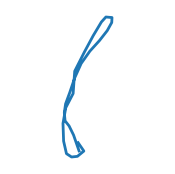

In [92]:
generate_text(9)